# Lab 2


`import interp` [scipy.interpolate.interp2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html)


## Objective

![theory](./Comparison_of_1D_and_2D_interpolation.svg)

## Code

In [76]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


### Load the image

Load and show the image inline.

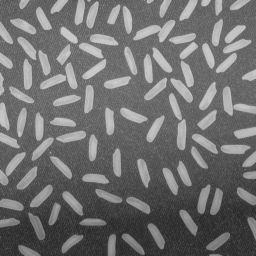

In [77]:
image = Image.open('rice.tif')
image

### Convert the image to numpy array

In [78]:
imarray = np.array(image)
print(imarray.shape)
print(imarray)

(256, 256)
[[122  92  95 ... 101 100  92]
 [ 99  99 102 ... 105  93  93]
 [ 97 107 103 ...  96  95 103]
 ...
 [ 51  58  46 ...  63  49  55]
 [ 52  52  53 ...  65  52  54]
 [ 59  51  52 ...  65  46  42]]


In [79]:
print(imarray.shape[0])

256


### Nearest neighbor

In [80]:
def Nearest_11812418(input_file, dim):
    image = Image.open(input_file)
    imarray = np.array(image)
    #find the dimenssion of input file
    input_height = imarray.shape[0]
    input_width = imarray.shape[1]

    #set the output
    #dim(0) is the height
    #dim(1) is the width
    #init an array
    output_arr = np.zeros(dim)

    #iterate in output array
    for i in range(dim[0]):
        for j in range(dim[1]):
            #i height (dim0)
            #j width (dim1)
            interpolation_h = round((i)*(input_height-1)/(dim[0]-1))
            interpolation_w = round((j)*(input_width-1)/(dim[1]-1))
            output_arr[i][j] = imarray[interpolation_h][interpolation_w]

    print(output_arr)
    return output_arr

#### Testbench

[[122.  92.  92. ... 100. 100.  92.]
 [ 99.  99.  99. ...  93.  93.  93.]
 [ 99.  99.  99. ...  93.  93.  93.]
 ...
 [ 52.  52.  52. ...  52.  52.  54.]
 [ 52.  52.  52. ...  52.  52.  54.]
 [ 59.  51.  51. ...  46.  46.  42.]]


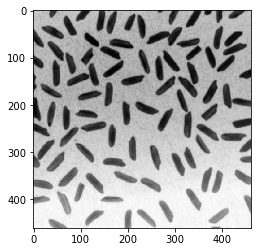

In [81]:
dim = (461,461)
output_img = Nearest_11812418('rice.tif',dim)

plt.imshow(output_img, cmap=plt.cm.Greys)
plt.show()

### Bilinear Interpolation

In [82]:
def Bilinear_11812418(input_file, dim):
    image = Image.open(input_file)
    imarray = np.array(image)
    #find the dimenssion of input file
    input_height = imarray.shape[0]
    input_width = imarray.shape[1]

    #set the output
    #dim(0) is the height
    #dim(1) is the width
    #init an array
    output_arr = np.zeros(dim)

    delta_height = 1
    delta_width = 1
    #base: output
    #iterate in output array
    for i in range(dim[0]):
        for j in range(dim[1]):
            #i height (dim0)
            #j width (dim1)

            #start from 1
            #transform to input coordinate
            projected_height = (i)*(input_height-1)/(dim[0]-1)
            projected_width = (j)*(input_width-1)/(dim[1]-1)
            #print(str(projected_height) + ' ' + str(projected_width))

            #find the border

            interpolation_h_up = int(np.ceil(projected_height))
            interpolation_h_down = int(np.floor(projected_height))
            interpolation_w_up = int(np.ceil(projected_width))
            interpolation_w_down = int(np.floor(projected_width))
            #print(str(interpolation_h_up)+' '+str(interpolation_h_down)+' '+str(interpolation_w_up)+' '+str(interpolation_w_down) + '\n')

            # delta_height = abs(interpolation_h_up-interpolation_h_down)
            # delta_width = abs(interpolation_w_up-interpolation_w_down)
            #
            # if int(delta_height)==0:
            #     delta_height = interpolation_h_up
            # if int(delta_width)==0:
            #     delta_width = interpolation_w_up


            k_w_down = (abs(imarray[interpolation_h_up][interpolation_w_down]-imarray[interpolation_h_down][interpolation_w_down]))/delta_height

            w_down_val = imarray[interpolation_h_down][interpolation_w_down] + k_w_down*(projected_height-interpolation_h_down)

            k_w_up = (abs(imarray[interpolation_h_up][interpolation_w_up]-imarray[interpolation_h_down][interpolation_w_up]))/delta_height
            w_up_val = imarray[interpolation_h_down][interpolation_w_up] + k_w_up*(projected_height-interpolation_h_down)


            #special case
            if(projected_height % 1):
                w_down_val = imarray[int(projected_height)][int(projected_width)]
                w_up_val = imarray[int(projected_height)][int(projected_width)]

            if(projected_width % 1):
                interpolation_w_down = projected_width

            k_h = (abs(w_up_val-w_down_val)/delta_width)
            h_val = w_down_val + k_h*(projected_width-interpolation_w_down)




            #interpolation_val = ((abs(interpolation_w_up-projected_width)*w_down_val+
            #                      abs(interpolation_w_down-projected_width)*w_up_val)/((interpolation_w_up+interpolation_w_down)*delta_width))
            #print(interpolation_val)

            output_arr[i][j] = h_val
    print(output_arr)
    return output_arr


#### Testbench

<ipython-input-82-e441ad51716a>:46: RuntimeWarning: overflow encountered in ubyte_scalars
  k_w_down = (abs(imarray[interpolation_h_up][interpolation_w_down]-imarray[interpolation_h_down][interpolation_w_down]))/delta_height
<ipython-input-82-e441ad51716a>:50: RuntimeWarning: overflow encountered in ubyte_scalars
  k_w_up = (abs(imarray[interpolation_h_up][interpolation_w_up]-imarray[interpolation_h_down][interpolation_w_up]))/delta_height


[[122. 122.  92. ... 101. 100.  92.]
 [122. 122.  92. ... 101. 100.  92.]
 [ 99.  99.  99. ... 105.  93.  93.]
 ...
 [ 51.  51.  58. ...  63.  49.  55.]
 [ 52.  52.  52. ...  65.  52.  54.]
 [ 59.  59.  51. ...  65.  46.  42.]]


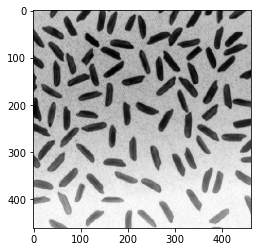

In [83]:
dim = (461,461)
output_img2 = Bilinear_11812418('rice.tif',dim)

plt.imshow(output_img2, cmap=plt.cm.Greys)
plt.show()



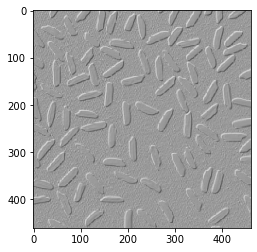

In [84]:
delta_img = output_img2-output_img

plt.imshow(delta_img, cmap=plt.cm.Greys)
plt.show()